# Preprocessing and random forest tuning

clean data, extract and select features

In [89]:
from __future__ import division
from pandas import DataFrame, read_csv
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib 
import numpy as np
%matplotlib inline

from urllib import urlopen
from bs4 import BeautifulSoup
import nltk 

from dateutil import parser
import pyprind

from difflib import SequenceMatcher

import seaborn as sns
sns.set(style="darkgrid", palette="muted")
import matplotlib
matplotlib.style.use('ggplot')
pd.set_option('display.notebook_repr_html', True)
plt.rcParams['figure.figsize'] = 10, 6

import warnings
warnings.filterwarnings('ignore')


from sklearn.cross_validation import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from itertools import product
from sklearn.ensemble import VotingClassifier
from sklearn import cross_validation
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score,log_loss
from sklearn.preprocessing import StandardScaler
from scipy.linalg import svd
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn import preprocessing

### Load the data

In [88]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
print df_train.columns.values
df_train[:3]

['AnimalID' 'Name' 'DateTime' 'OutcomeType' 'OutcomeSubtype' 'AnimalType'
 'SexuponOutcome' 'AgeuponOutcome' 'Breed' 'Color']


,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White


### define functions for preprocessing

The idea is to obtain the higher number of features as possible from the raw data. One column is also created for each values of the categorical attributes (breed and color).
The missing data are replaced with basic values or the average (age).

In [3]:
# utility functions
def getSplitableAttribute(u): # split an attribute with the caracter '/' and remove the pattern ' Mix'
    u = u.replace(' Mix' , '')
    return u.split('/')
def getUniques( df, attr): # get all uniques attributes for a sequence of splitable attributes
    uniques = set()
    for u in df[attr]:
        for uu in getSplitableAttribute(u):
            uniques.add(uu)
    return list(uniques)

In [4]:
unique_breeds = set( getUniques( df_train , 'Breed' ) + getUniques( df_test , 'Breed' ) ) 
unique_colors = set( getUniques( df_train , 'Color' ) + getUniques( df_test , 'Color' ) )

In [200]:
# get featuress from data
def getMonth(datetime):
    dt = parser.parse(datetime)
    return dt.month
def getHour(datetime):
    dt = parser.parse(datetime)
    return dt.hour
def getMinute(datetime):
    dt = parser.parse(datetime)
    return dt.minute
def getDay(datetime):
    dt = parser.parse(datetime)
    return dt.day
def isNotIntact(x):
    if x==x:
        return int(('Neutered' in x or 'Spayed' in x))
    else:
        return 0 # set a default value if NaN
def isMale(x):
    if x==x:
        return float('Male' in x)
    else:
        return 0 # set a default value if NaN
def isFemale(x):
    if x==x:
        return float('Female' in x)
    else:
        return 0 # set a default value if NaN
def isUnknow(x):
    return int(not x==x)

# get age in days 
def getAge(age):
    if age==age:
            value = int(age.split(' ')[0])
            unit = age.split(' ')[1]
            factor = 1
            if unit == 'weeks' or unit == 'week':
                factor = 7
            elif unit == 'month' or unit == 'months':
                factor = 31
            elif unit == 'year' or unit == 'years':
                factor = 365  
            return value*factor
    else:
        return -1 # set a default value if NaN

# get age for a given unit. 
def getAgeUnit(age, timeUnit):
    if age==age:
            value = int(age.split(' ')[0])
            unit = age.split(' ')[1]
            if unit == timeUnit or unit == timeUnit+'s':
                return value
            else:
                return 0
    else:
        return 0 # set a default value if NaN

In [201]:
def preprocess(df):
    # color
    # get the number of color and 
    for color in unique_colors: # turn categorical attribute into binary ones
        df['Color='+color] = df['Color'].map(lambda x : int(color in getSplitableAttribute(x)) )
    df['ColorCount'] = df['Color'].map(lambda x : len(getSplitableAttribute(x)))
    df = df.drop('Color', 1)
    # breed
    for breed in unique_breeds: # turn categorical attribute into binary ones
        df['Breed='+breed] = df['Breed'].map(lambda x : int(breed in getSplitableAttribute(x)) )
    df['BreedCount'] = df['Breed'].map(lambda x : len(getSplitableAttribute(x)))
    df['isMix'] = df['Breed'].map(lambda x: int('Mix' in x))
    df = df.drop('Breed', 1)
    # has name
    df['HasName'] = df['Name'].map( lambda x: int(int(x==x) ) )
    df = df.drop('Name' , 1)
    # DateTime
    df['Hour'] = df['DateTime'].map(getHour)
    df['Minute'] = df['DateTime'].map(getMinute)
    df['Month'] = df['DateTime'].map(getMonth)
    df['Day'] = df['DateTime'].map(getDay)
    df = df.drop('DateTime',1)
    # sex 
    df['isNotIntact'] = df['SexuponOutcome'].map(isNotIntact)
    df['isFemale'] = df['SexuponOutcome'].map(isFemale)
    df = df.drop('SexuponOutcome',1)
    # age
    df['AgeInDays'] = df.AgeuponOutcome.map( lambda x : getAgeUnit(x , 'day') )
    df['AgeInWeeks'] = df.AgeuponOutcome.map( lambda x : getAgeUnit(x , 'week') )
    df['AgeInMonths'] = df.AgeuponOutcome.map( lambda x : getAgeUnit(x , 'month') )
    df['AgeInYears'] = df.AgeuponOutcome.map( lambda x : getAgeUnit(x , 'year') )
    df['Age'] = df.AgeuponOutcome.map( getAge )
    df = df.drop( 'AgeuponOutcome' , 1)
    # Animal Type 
    df['isCat'] = df['AnimalType'].map(lambda x : int('Cat' in x ) )
    df = df.drop('AnimalType', 1)
    # handle missing values
    mean_age = np.mean(df['Age'])
    df['Age'] = df.Age.map( lambda x : mean_age if x < 0 else x) # fill missing age values
    return df

In [206]:
# preprocess the data set and save it
df_train = pd.read_csv('train_breed_infos.csv') # load the data containing the breed scores
df_train = df_train.drop('Unnamed: 0', 1)
df_test = pd.read_csv('test_breed_infos.csv')
print "preprocessing train data.."
print
df_train = preprocess(df_train)
print "preprocessing test data.."
print
df_test = preprocess(df_test)

df_train.to_csv("preprocessing_train_3.csv")
df_test.to_csv("preprocessing_test_3.csv")

features = list(df_train.columns.values)
features.remove('OutcomeType')
features.remove('OutcomeSubtype')
features.remove('AnimalID')
fs = []
for f in features:
    if 'Breed=' not in f and 'Color=' not in f:
        print f + ' ',
        fs.append(f)
        
print
print len(df_train.columns.values),
print ' features'

preprocessing train data..

preprocessing test data..

BreedScore  ColorCount  BreedCount  isMix  HasName  Hour  Minute  Month  Day  isNotIntact  isFemale  AgeInDays  AgeInWeeks  AgeInMonths  AgeInYears  Age  isCat 
315  features


In [197]:
df_train[fs][:3]

,BreedScore,ColorCount,BreedCount,isMix,HasName,Hour,Minute,Month,Day,isNotIntact,isFemale,AgeInDays,AgeInWeeks,AgeInMonths,AgeInYears,Age,isCat
0,0.857143,2,1,1,1,18,22,2,12,1,0,0,0,0,1,365,0
1,0.823529,1,1,1,1,12,44,10,13,1,1,0,0,0,1,365,1
2,0.000000,2,1,1,1,12,28,1,31,1,0,0,0,0,2,730,0


In [198]:
df_test[fs][:3]

,BreedScore,ColorCount,BreedCount,isMix,HasName,Hour,Minute,Month,Day,isNotIntact,isFemale,AgeInDays,AgeInWeeks,AgeInMonths,AgeInYears,Age,isCat
0,0.888889,2,1,1,1,12,15,10,12,0,1,0,0,10,0,310,0
1,0.749020,2,2,0,1,17,59,7,26,1,1,0,0,0,2,730,0
2,0.823529,1,1,1,1,12,20,1,13,1,0,0,0,0,1,365,1


# Features Selection

In this section we try to reduce the total number of features in order to make the job easier for the classifiers.

First, we calculate the correlation coefficient between 'isMix' and BreedCount: if an animal has a mixed breed, it must has 2 breeds. However we observe that the coefficient is still high. Therefore we keep the two features.

In [179]:
np.corrcoef(df_train['isMix'] , df_train['BreedCount'])

array([[ 1.        , -0.79916199],
       [-0.79916199,  1.        ]])

Then, I use a random forest classifier in order to calculate the importance of each features based on the GINI scores.

In [175]:
y = df_train["OutcomeType"]
features_selected = features[:]
X = df_train[features_selected]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model =  RandomForestClassifier(n_estimators=500, random_state=12)
print str(X_train.shape[1]) + ' features'
print str(X_train.shape[0]) + ' rows\n'
print 'Fitting...\n'
model.fit(X_train, y_train)
print 'Predicting...\n'
y_pred = model.predict(X_test)
print accuracy_score(y_test, y_pred), ' accuracy.\n'

312 features
21383 rows

Fitting...

Predicting...

0.677890011223  accuracy.



In [162]:
feat_imps= model.feature_importances_
features_importance = []
for i in range(len(features_selected)):
    features_importance.append(  ( features_selected[i]  , feat_imps[i] ) )

In [178]:
sorted_feats = sorted( features_importance , key = lambda x : x[1] , reverse = True )
for p in sorted_feats[:30]:
    print p[0] + '  ' + str(p[1])

Minute  0.102370656584
Hour  0.0956407405325
isNotIntact  0.0879925723742
Day  0.0839477901991
Age  0.0821258993044
Month  0.0696016091703
AgeInYears  0.0551226255352
HasName  0.0446521581114
AgeInMonths  0.0404238260823
BreedScore  0.0280674931483
isFemale  0.0176031949406
AgeInWeeks  0.0153008972391
isCat  0.0149547175503
Color=Black  0.0146600275405
Color=White  0.0136617002184
ColorCount  0.0129321893313
Breed=Domestic Shorthair  0.0100940585049
Color=Brown  0.00926536223182
isMix  0.00892971227584
Color=Tan  0.00879764711784
Breed=Pit Bull  0.00653346789997
Color=Blue  0.00593635299662
Breed=Chihuahua Shorthair  0.00592212291237
BreedCount  0.00567219392855
Color=Red  0.00486629167741
Breed=Labrador Retriever  0.00484589797784
Color=Brown Tabby  0.00474773789223
Color=Brown Brindle  0.00453366680041
Color=Tricolor  0.0037851112822
Breed=German Shepherd  0.00358912577011


As we can see, the information about the time are very important, as well as the information about the age and the sex.

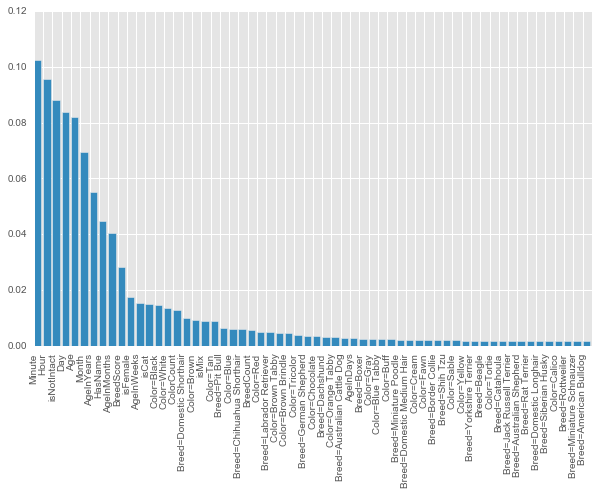

In [190]:
n = 60
values = [ f[1] for f in sorted_feats][:n]
labels = [ f[0] for f in sorted_feats][:n]
plt.bar( range(len(values)), values )
plt.xticks(range(len(values)), labels, rotation='vertical')
plt.show()

As shown on the chart above, Only the first features are really important. we can keep only 10% of the total number of features (initially around 300). I select the best number of features with cross validation as shown bellow.

In [203]:
results = []
for n in range(30,60,10):
    print 'n: ' + str(n),
    scores = []
    for i in range(3):
        print 'seed: ' + str(i), 
        selected_features2 = [ f[0] for f in sorted_feats][:n]
        y = df_train["OutcomeType"]
        X = df_train[selected_features2]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
        model =  RandomForestClassifier(n_estimators=500, random_state=12)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        scores.append(score)
    print np.mean(scores),
    print ' accuracy.'
    results.append( {'n':n , 'score' : np.mean(scores) , 'scores' : scores})

n: 30 seed: 0 seed: 1 seed: 2 0.68287816436  accuracy.
n: 40 seed: 0 seed: 1 seed: 2 0.680446439706  accuracy.
n: 50 seed: 0 seed: 1 seed: 2 0.680321735877  accuracy.


The best value regarding to the accuracy is 55 features. (I ran the cell above with different ranges of values)

In [191]:
feats = pd.DataFrame( [ f[0] for f in sorted_feats][:55] )
feats.to_csv('features.csv')

## Random forest tuning
The next cell has been ran several times with different parameters in order to find the best parameters for our classifier. The score for the simple random forest classifier is already quite good!

In [204]:
y = df_train["OutcomeType"]
features_selected = features[:]
#features_selected.remove('isMix') 
X = df_train[selected_features2]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model =  RandomForestClassifier(n_estimators=300, random_state=12, min_samples_split = 3, min_samples_leaf = 2, n_jobs=4)
print str(X_train.shape[1]) + ' features'
print str(X_train.shape[0]) + ' rows\n'
print 'Fitting...\n'
model.fit(X_train, y_train)
print 'Predicting...\n'
y_pred = model.predict(X_test)
print accuracy_score(y_test, y_pred), ' accuracy.\n'

50 features
21383 rows

Fitting...

Predicting...

0.679947624392  accuracy.



# NB: the data is normalized in the notebook fit, predict and submit"